# Introduction

Apache Spark is an open-source, distributed processing system used for big data workloads. It utilizes in-memory caching, and optimized query execution for fast analytic queries against data of any size. The police crime data is huge after exploring the dataset. The approach taken to solve the problem is executing the programme in apache spark using the module container. The Pyspark sql is used for Data Extraction, Filtering and Time series is used for the forecasting. This study uses crime dataset from United Kingdom police service with over 60 million data. The police recorded crime data which have 16 crime types in total.

In [97]:
# importing all necesary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkFiles
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
import itertools
import statsmodels.api as sm

# Loading the data into Spark

The first step in using Spark is connecting to a cluster. In practice, the cluster will be hosted on a remote machine that's connected to all other nodes. There will be one computer, called the master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called worker. The master sends the workers data and calculations to run, and they send their results back to the master (Shao, 2020)

In addition to that, the syntax for running locally or using many clusters are pretty similar. To start working with Spark DataFrames, we first have to create a SparkSession object from SparkContext. We can think of the SparkContext as the connection to the cluster and SparkSession as the interface with that connection. Let's create a SparkSession.

 
To load the data I am using Spark DataFrames. Spark it’s a little bit more complicated than Pandas. You can’t just do “import -> read_csv()”. You first need to start a Spark Session



In [12]:
spark = SparkSession \
    .builder \
    .appName('Big Data Product: Violent Crime in Lockdown Britain') \
    .getOrCreate()

spark

The above output means that I am using Spark locally with all the cores (that’s the *), with version 3.1.2 and the name of the session is “Big Data Product: Violent Crime in Lockdown Britain”.

So, **Let's read the dataset.** 


In [14]:
spark_context=spark.sparkContext

url = "https://yusuf.blob.core.windows.net/container20027750/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)


In [15]:
# As you can see it's a Spark dataframe. Let's take a look at the preview of the crime dataset. 
df.show()
print ("Total Number of data in the dataset")
df.count()


+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

65078250

# Crime Category

The category the police use in the dataset is the crime type. There are total number of 16 crimes in the dataset which are shown below.

In [16]:
crime_category = (df.select('*')
        .groupBy('Crime Type')
        .agg(count("Crime Type").alias('Total Crime'))
        .orderBy('Crime Type')
               )

In [17]:
crime_category_filter=crime_category.select("Crime Type")
crime_category_filter.show()


+--------------------+
|          Crime Type|
+--------------------+
|Anti-social behav...|
|       Bicycle theft|
|            Burglary|
|Criminal damage a...|
|               Drugs|
|         Other crime|
|         Other theft|
|Possession of wea...|
|Public disorder a...|
|        Public order|
|             Robbery|
|         Shoplifting|
|Theft from the pe...|
|       Vehicle crime|
|Violence and sexu...|
|       Violent crime|
+--------------------+



In [18]:
crime_category_filter_pd= crime_category_filter.toPandas()
crime_category_filter_pd


,Crime Type
0,Anti-social behaviour
1,Bicycle theft
2,Burglary
3,Criminal damage and arson
4,Drugs
5,Other crime
6,Other theft
7,Possession of weapons
8,Public disorder and weapons
9,Public order


# Consistency of Crime Category

Exploring my dataset in other to see if the same categories been used consistently. Using Pyspark Sql, I decided to query all the column and then group it by the crime type and the Month. Each crime that happended in a month has a total and this is done by using the aggregate function and count the total number of crime for each month. The crime category is not consistent as violent crime stopped in 2013.

In [19]:
crime_category_ds = (df.select('*')
        .groupBy('Crime Type', 'Month')
        .agg(count("Crime Type").alias('Total Crime'))
        .orderBy('Month')
               )
print("Showing Crime Type that happened every month of the year from 2010 to 2021")
crime_category_ds.show()

print("Out of ")
crime_category_ds.count()



Showing Crime Type that happened every month of the year from 2010 to 2021
+--------------------+-------+-----------+
|          Crime Type|  Month|Total Crime|
+--------------------+-------+-----------+
|            Burglary|2010-12|      37893|
|Anti-social behav...|2010-12|     201016|
|       Violent crime|2010-12|      57580|
|             Robbery|2010-12|       5731|
|         Other crime|2010-12|     142705|
|       Vehicle crime|2010-12|      29416|
|             Robbery|2011-01|       6667|
|            Burglary|2011-01|      44388|
|       Violent crime|2011-01|      59823|
|Anti-social behav...|2011-01|     201792|
|         Other crime|2011-01|     167072|
|       Vehicle crime|2011-01|      34899|
|       Vehicle crime|2011-02|      33591|
|Anti-social behav...|2011-02|     206801|
|         Other crime|2011-02|     168945|
|             Robbery|2011-02|       6480|
|            Burglary|2011-02|      41821|
|       Violent crime|2011-02|      56691|
|       Violent crime|

1632

I know the above output is not that pretty. One good thing about using Python is that it interacts with Pandas easily. In other to show our data in a prettier format and also converting the data to pandas, I use toPandas(). The reason why I am doing this is because the data I am working with is small enough after filtering it to each month of the year by using the variable "crime_category_ds" to hold the data. When using “toPandas()” it will get all the data at once, and it won’t be distributed in that cell. So it will have to fit in Memory. The below output shows how the data is being converted and with this, I am able to plot the crime category which is shown below.

In [20]:
#Converting the crime_category_ds toPandas and storing it in crime_category_pd
crime_category_pd = crime_category_ds.toPandas()

#Showing the crime category in the prettier format
crime_category_pd 


,Crime Type,Month,Total Crime
0,Violent crime,2010-12,57580
1,Robbery,2010-12,5731
2,Anti-social behaviour,2010-12,201016
3,Other crime,2010-12,142705
4,Burglary,2010-12,37893
...,...,...,...
1627,Drugs,2021-05,15383
1628,Anti-social behaviour,2021-05,118045
1629,Other theft,2021-05,28979
1630,Violence and sexual offences,2021-05,171614


The data is visualized to see how the whether the data is consistent or not. The data is not consistent; for example violent crime stopped at 2013. For Violence and sexual offences, it started from 2014.


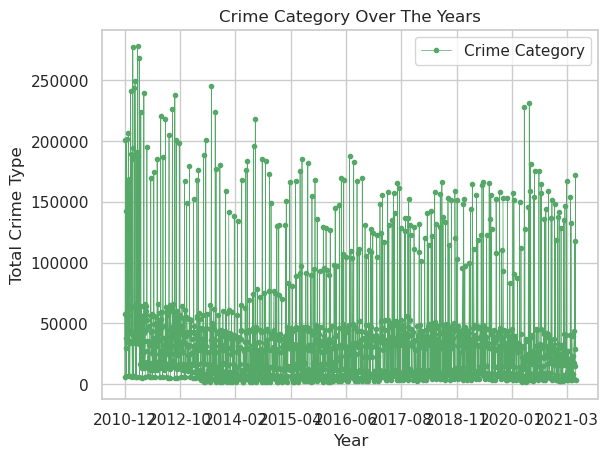

In [26]:
plt.figsize=(20, 6)
crime_category_pd.plot(y='Total Crime', x='Month',marker='.',color='g', linestyle='-', linewidth=0.5,\
         subplots=False,
         label='Crime Category',
         title='Crime Category Over The Years')
plt.ylabel('Total Crime Type')
plt.xlabel('Year')

plt.legend()
plt.show()



Another way to visualize is using seabon, the line plot graph shows the trend of the crime category.

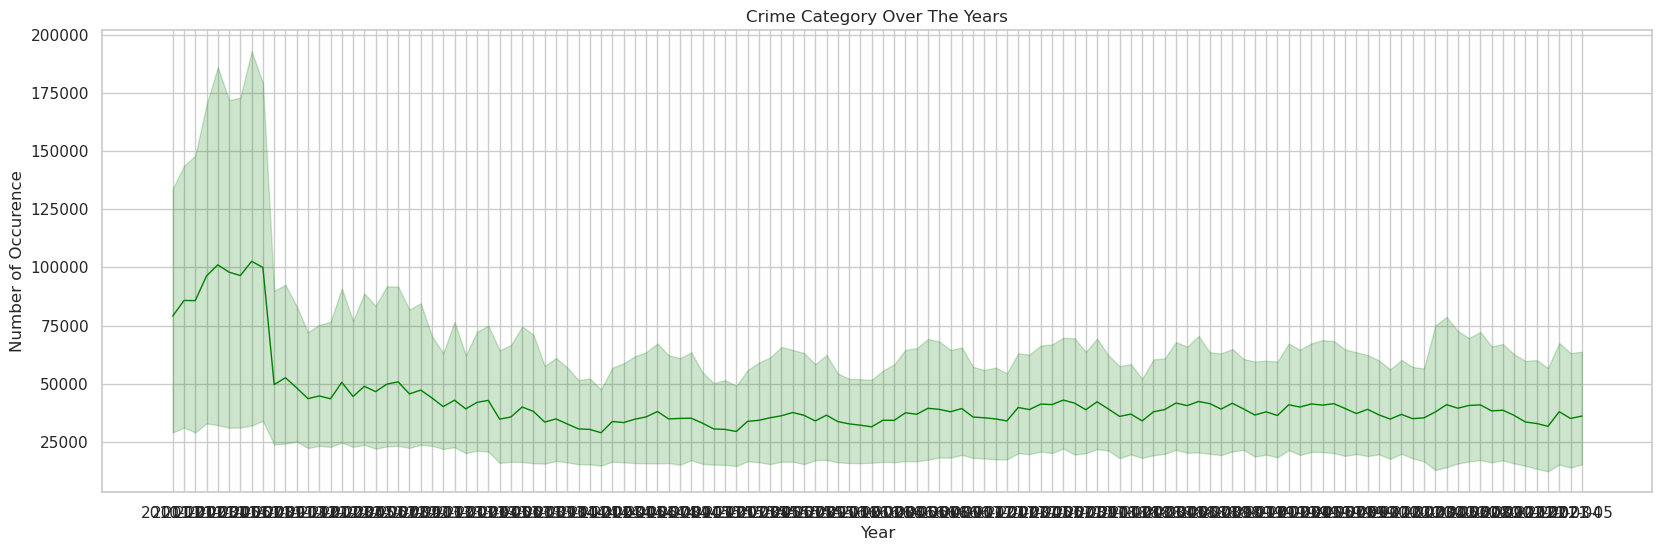

In [290]:
plt.figure(figsize=(20, 6))
# line plot for seaborn
ax = sns.lineplot(data=crime_category_pd,x='Month',y="Total Crime", color='green', linewidth=1)
ax.set_title("Crime Category Over The Years")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Occurence")
plt.show()

# Levels of Violence and sexual offences

Since the Violent crime stops in 2013, the violence and sexual offences is used. The dataset is being explored to see if the levels of violence and sexual offences is constant, increasing, or decreasing, 

# Levels of Violent Crime

The level of violent crime stopped in 2013. The crime data is filtered to see the total number of crime for each month.

In [22]:
# using select query to filter the violent crime from the crime type. Each monthly violent crime is counted using the
# aggregate function and it is being sorted by month

violent_crime= (df.select('*')
        .where(df['Crime type']=='Violent crime')
        .groupBy('Crime Type', 'Month')
        .agg(count("Crime Type").alias('Total Crime'))
        .orderBy('Month')
               )
# to see the internals of the DataFrame, the show() is used
violent_crime.show()

# counting the number of times the violent crime occured 
violent_crime.count()


+-------------+-------+-----------+
|   Crime Type|  Month|Total Crime|
+-------------+-------+-----------+
|Violent crime|2010-12|      57580|
|Violent crime|2011-01|      59823|
|Violent crime|2011-02|      56691|
|Violent crime|2011-03|      62326|
|Violent crime|2011-04|      64299|
|Violent crime|2011-05|      63633|
|Violent crime|2011-06|      62475|
|Violent crime|2011-07|      66572|
|Violent crime|2011-08|      63284|
|Violent crime|2011-09|      57150|
|Violent crime|2011-10|      60076|
|Violent crime|2011-11|      56895|
|Violent crime|2011-12|      56163|
|Violent crime|2012-01|      56324|
|Violent crime|2012-02|      50598|
|Violent crime|2012-03|      58606|
|Violent crime|2012-04|      53415|
|Violent crime|2012-05|      59541|
|Violent crime|2012-06|      56816|
|Violent crime|2012-07|      60199|
+-------------+-------+-----------+
only showing top 20 rows



29

In [23]:
# converting the violent crime to pandas
violent_crime_ds = violent_crime.toPandas()
violent_crime_ds


,Crime Type,Month,Total Crime
0,Violent crime,2010-12,57580
1,Violent crime,2011-01,59823
2,Violent crime,2011-02,56691
3,Violent crime,2011-03,62326
4,Violent crime,2011-04,64299
5,Violent crime,2011-05,63633
6,Violent crime,2011-06,62475
7,Violent crime,2011-07,66572
8,Violent crime,2011-08,63284
9,Violent crime,2011-09,57150


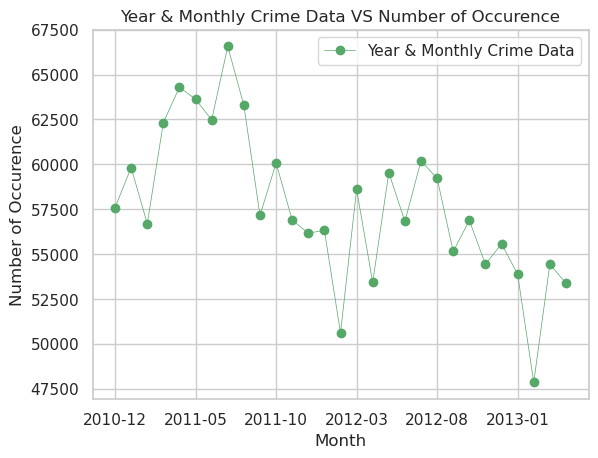

In [24]:
# using matplotlib to display how the violent crime is over the years with respect to it's total.

plt.figsize=(20, 6)

# The plot() function in pyplot module of matplotlib library is used to make a 2D hexagonal binning plot of 
# points x, y which accepts the following parameters that are used below.
violent_crime_ds.plot(y='Total Crime', x='Month',marker='o',color='g', linestyle='-', linewidth=0.5,\
         subplots=False,
         label='Year & Monthly Crime Data',
         title='Year & Monthly Crime Data VS Number of Occurence')
plt.ylabel('Number of Occurence')
plt.legend()
plt.show()



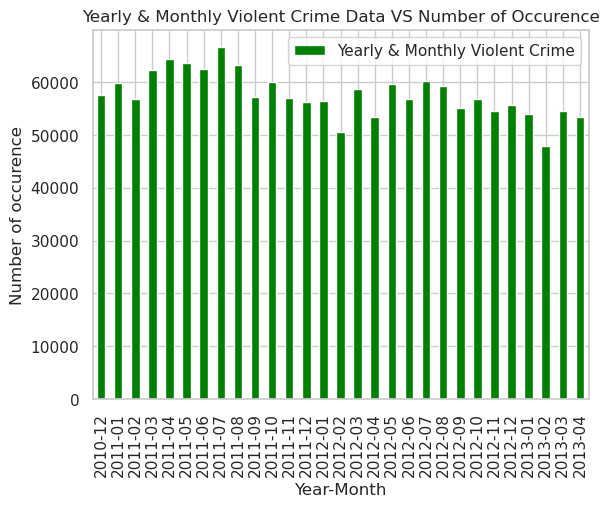

In [274]:
plt.figsize=(20, 6)

# The plot() function in pyplot module of matplotlib library is used to make a 2D hexagonal binning plot of 
# points x, y which accepts the following parameters that are used below. the kind ="bar" specifies the type of graph
violent_crime_ds.plot(y='Total Crime', x='Month', kind='bar',facecolor='green',\
         subplots=False,
         label='Yearly & Monthly Violent Crime',
         title='Yearly & Monthly Violent Crime Data VS Number of Occurence')
plt.xlabel('Year-Month')
plt.ylabel('Number of occurence')


plt.show()



# Levels of Violence and sexual offences

The Violence and sexual offences started in 2014 and the dataset is being filtered to see the behaviour of the crime.

In [30]:
# using select query to filter the Violence and sexual offences from the crime type. 
# Each monthly Violence and sexual offences is counted using the aggregate function and it is being sorted by month

violence_sexual_offence = (df.select('*')
        .where(df['Crime type']=='Violence and sexual offences')
        .groupBy('Crime Type', 'Month')
        .agg(count("Crime Type").alias('Total'))
        .orderBy('Month')
               )

               )
# to see the internals of the DataFrame, the show() is used

violence_sexual_offence.show()


# counting the number of times the violent crime occured 
violence_sexual_offence.count()


+--------------------+-------+-----+
|          Crime Type|  Month|Total|
+--------------------+-------+-----+
|Violence and sexu...|2013-05|57031|
|Violence and sexu...|2013-06|57815|
|Violence and sexu...|2013-07|64962|
|Violence and sexu...|2013-08|61607|
|Violence and sexu...|2013-09|56964|
|Violence and sexu...|2013-10|60016|
|Violence and sexu...|2013-11|58231|
|Violence and sexu...|2013-12|61087|
|Violence and sexu...|2014-01|59291|
|Violence and sexu...|2014-02|56798|
|Violence and sexu...|2014-03|65372|
|Violence and sexu...|2014-04|62825|
|Violence and sexu...|2014-05|69063|
|Violence and sexu...|2014-06|74066|
|Violence and sexu...|2014-07|78459|
|Violence and sexu...|2014-08|71341|
|Violence and sexu...|2014-09|74723|
|Violence and sexu...|2014-10|76405|
|Violence and sexu...|2014-11|76358|
|Violence and sexu...|2014-12|74820|
+--------------------+-------+-----+
only showing top 20 rows



97

In [31]:
# converting the violence and sexual offences to pandas
violence_sexual_offence_pd = violence_sexual_offence.toPandas()
violence_sexual_offence_pd


,Crime Type,Month,Total
0,Violence and sexual offences,2013-05,57031
1,Violence and sexual offences,2013-06,57815
2,Violence and sexual offences,2013-07,64962
3,Violence and sexual offences,2013-08,61607
4,Violence and sexual offences,2013-09,56964
...,...,...,...
92,Violence and sexual offences,2021-01,141414
93,Violence and sexual offences,2021-02,135101
94,Violence and sexual offences,2021-03,166668
95,Violence and sexual offences,2021-04,153789


The MatplotLib is used to plot the graph of whether the Violence and sexual offences is constant, increasing or decreasing. The level of the crime is increasing over the years which can be seen below.

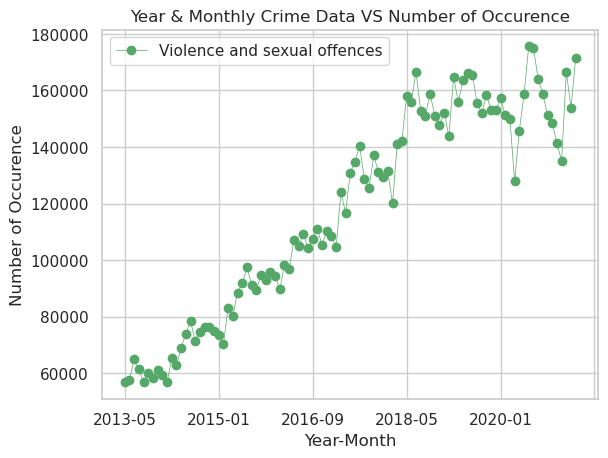

In [22]:
plt.figsize=(20, 6)
# The plot() function in pyplot module of matplotlib library is used to make a 2D hexagonal binning plot of 
# points x, y which accepts the following parameters that are used below.
violence_sexual_offence_pd.plot(y='Total', x='Month',marker='o',color='g', linestyle='-', linewidth=0.5,\
         subplots=False,
         label='Violence and sexual offences',
         title='Year & Monthly Crime Data VS Number of Occurence')
# display text for y axis
plt.ylabel('Number of Occurence')
# display text for x axis
plt.xlabel('Year-Month')

# show plot
plt.show()




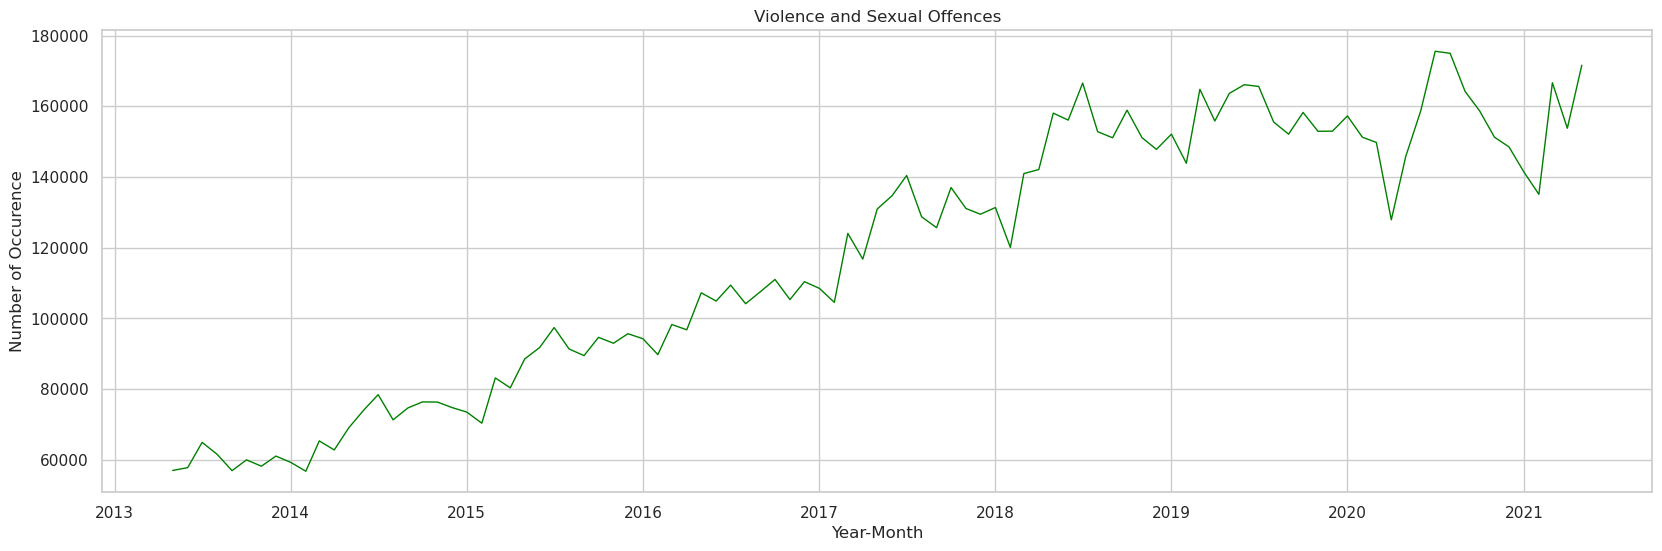

In [267]:
plt.figure(figsize=(20, 6))
# The lineplot() function in seaborn module 
# points x, y which accepts the following parameters that are used below.
ax = sns.lineplot(data=violence_sexual_offence_pd,x='Month',y="Total", color='green', linewidth=1)
ax.set_title("Violence and Sexual Offences")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Number of Occurence")
plt.show()

# Forecasting with a Time Series Model

Creating a time series model in Python allows us to capture more of the complexity of the data and includes all of the data elements that might be important. It also makes it possible to make adjustments to different measurements, tuning the model to make it potentially more accurate.

Of course, the predictive power of a model is not really known until we get the actual data to compare it to. Given that the Python modeling captures more of the data’s complexity, the prediction is expected to be more accurate than a linear trendline.

In [306]:
# executing to know the dataframe data type for each column
violence_sexual_offence


DataFrame[Crime Type: string, Month: string, Total: bigint]

In [321]:
violence_sexual_offence_pd

,Crime Type,Month,Total
0,Violence and sexual offences,2013-05,57031
1,Violence and sexual offences,2013-06,57815
2,Violence and sexual offences,2013-07,64962
3,Violence and sexual offences,2013-08,61607
4,Violence and sexual offences,2013-09,56964
...,...,...,...
92,Violence and sexual offences,2021-01,141414
93,Violence and sexual offences,2021-02,135101
94,Violence and sexual offences,2021-03,166668
95,Violence and sexual offences,2021-04,153789


I took some preparation steps with the dataset so that it’s slightly cleaner. I checked for missing data for the Date and the "day" is missing. The Date is converted from string to datetime. The value in the date will be in YYYY-MM-DD date format 

In [326]:
# converting the Month from String to datetime
violence_sexual_offence_pd["Month"]=violence_sexual_offence_pd["Month"].astype('datetime64[ns]')
violence_sexual_offence_pd2 = violence_sexual_offence_pd.set_index(pd.to_datetime(violence_sexual_offence_pd['Month']))



In [324]:
violence_sexual_offence_pd2


,Crime Type,Month,Total,Year
Month,,,,
2013-05-01,Violence and sexual offences,2013-05-01,57031,2013-05-01
2013-06-01,Violence and sexual offences,2013-06-01,57815,2013-06-01
2013-07-01,Violence and sexual offences,2013-07-01,64962,2013-07-01
2013-08-01,Violence and sexual offences,2013-08-01,61607,2013-08-01
2013-09-01,Violence and sexual offences,2013-09-01,56964,2013-09-01
...,...,...,...,...
2021-01-01,Violence and sexual offences,2021-01-01,141414,2021-01-01
2021-02-01,Violence and sexual offences,2021-02-01,135101,2021-02-01
2021-03-01,Violence and sexual offences,2021-03-01,166668,2021-03-01


It’s very important to check any time series data for patterns that can affect the results, and can inform which forecasting model to use. The statsmodels library allow the decomposition and display of the data into seasonal, trend, and residual components. The time series data patterns here are:

1. **Trend**: Increases, decreases, or stays the same over time.
2. **Seasonal**: Pattern repeats periodically over time.
3. **Resid**: The residual is what's left over after trends and seasonality are removed.

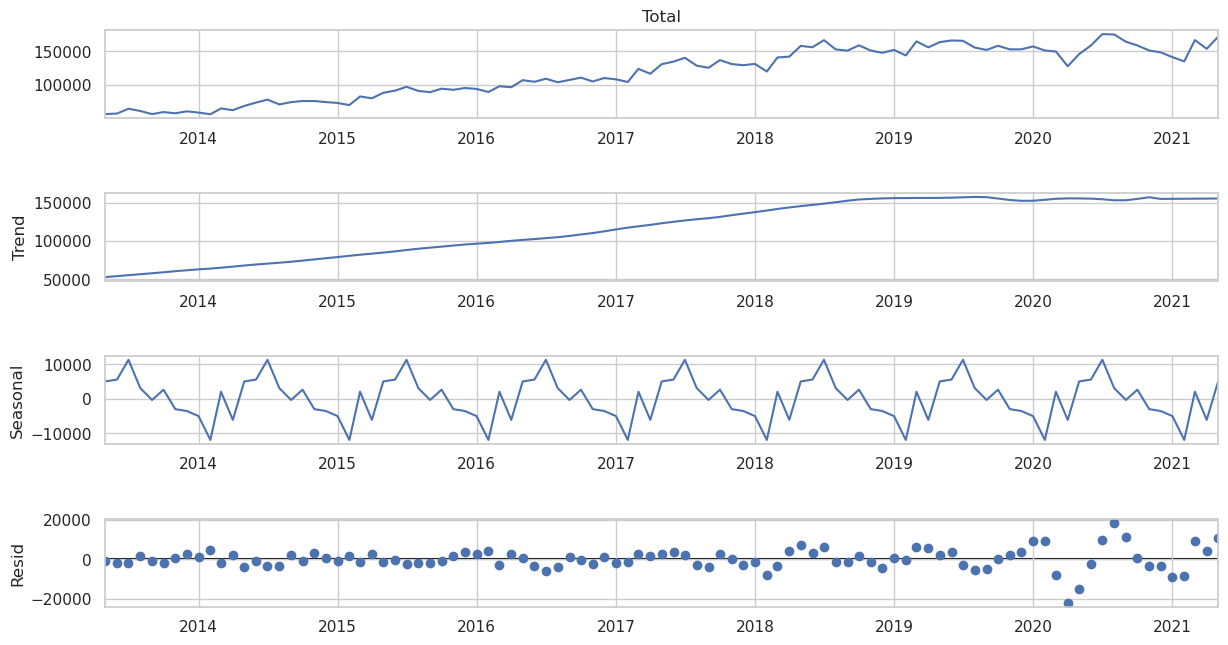

In [327]:
decomposition = sm.tsa.seasonal_decompose(violence_sexual_offence_pd2['Total'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()


After looking at the four pieces of decomposed graphs, it is easy to see that the violence and sexual offences  has an overall increasing trend. The evaluating and choosing model is discussed further below.

In [331]:
decomposition.seasonal



Month
2013-05-01     5055.197963
2013-06-01     5604.976638
2013-07-01    11343.877735
2013-08-01     3116.440289
2013-09-01     -316.606531
                  ...     
2021-01-01    -5008.489344
2021-02-01   -11927.150237
2021-03-01     2067.063869
2021-04-01    -6101.972025
2021-05-01     5055.197963
Name: seasonal, Length: 97, dtype: float64

In [88]:
# dropping the data that are null and getting the data for analysis and prediction.
y=violence_sexual_offence_pd2.set_index(pd.to_datetime(violence_sexual_offence_pd2['Month'])).dropna().Total


<h1>Check for Stationarity</h1>

Next, I need to check whether the violence and sexual offences data is stationary or not. A dataset is said to be stationary if its statistical properties like mean, variance, and autocorrelation do not change over time. since most time-series forecasting models use stationarity to make predictions, I need to "**stationarize**" the time series as part of the process of fitting a model.


<h3>Visualization</h3>

This method below graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time

In [123]:
def test_stationarity(timeseries, title):

#Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

<h3>Augmented Dickey-Fuller Test</h3>

I use the Augmented Dickey-Fuller Test method to check whether the Time Series is stationary or not with different levels of confidence. The Augmented Dickey-Fuller Test (ADF) approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Since this will be repeated several times so it is embedded  into a function.

In [118]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

 > Is the violence and sexual offences data stationary ?
Test statistic = -1.757
P-value = 0.402
Critical values :
	1%: -3.510711795769895 - The data is not stationary with 99% confidence
	5%: -2.8966159448223734 - The data is not stationary with 95% confidence
	10%: -2.5854823866213152 - The data is not stationary with 90% confidence


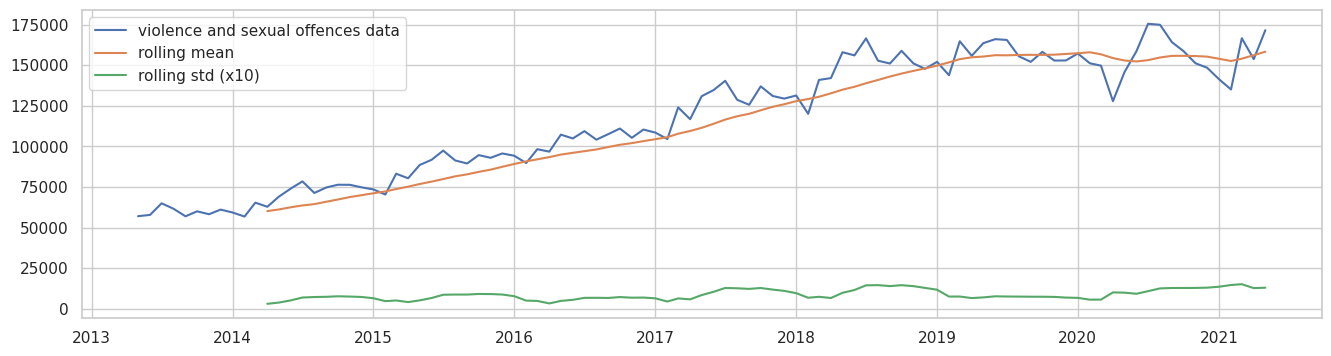

In [337]:
# importing adfuller from statsmodels package
from statsmodels.tsa.stattools import adfuller

test_stationarity(y,'violence and sexual offences data')
ADF_test(y,"violence and sexual offences data")
plt.show()

Looking at both the visualization and ADF test above, it can be deduced that violence and sexual offences data is non-stationary. 

<h2>Making the Data Stationary</h2>

To proceed with my time series analysis, I need to stationarize the dataset. There are many approaches to stationarize data, but firstly, I am using **de-trending**. This method removes the underlying trend in the time series.

<h3>Detrending</h3>

 > Is the de-trended data stationary ?
Test statistic = -1.051
P-value = 0.734
Critical values :
	1%: -3.5232835753964475 - The data is not stationary with 99% confidence
	5%: -2.902030597326081 - The data is not stationary with 95% confidence
	10%: -2.5883710883843123 - The data is not stationary with 90% confidence


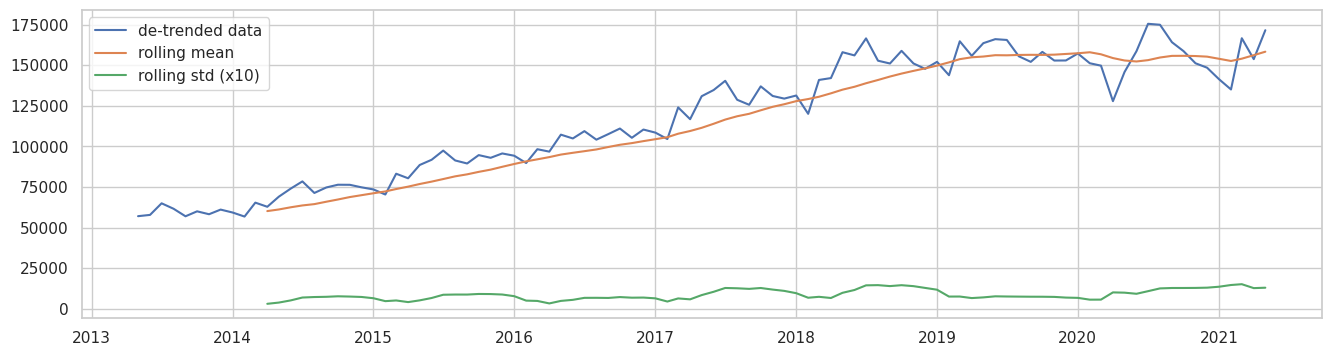

In [343]:
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()
test_stationarity(y,'de-trended data')
ADF_test(y_detrend,"de-trended data")
plt.show()

The results above for de-trend show that the data is still not stationary

Another approach to stationarize the data is **Differencing**.
With Differencing method, it removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference.

<h3>Differencing</h3>

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.433
P-value = 0.566
Critical values :
	1%: -3.524624466842421 - The data is not stationary with 99% confidence
	5%: -2.9026070739026064 - The data is not stationary with 95% confidence
	10%: -2.5886785262345677 - The data is not stationary with 90% confidence


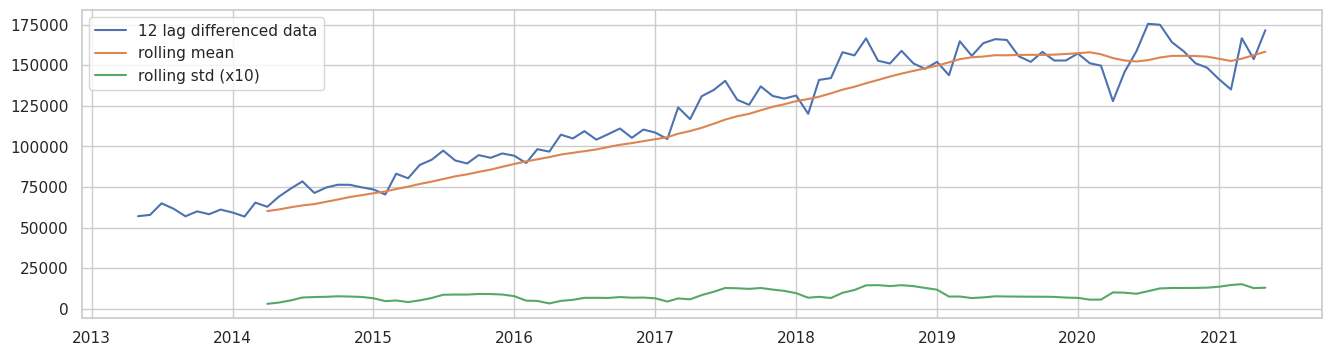

In [345]:
y_12lag =  y - y.shift(12)
test_stationarity(y,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')
plt.show()

The results above for Differencing show that the data is still not stationary.

<h3>Combination of Detrending and Differencing</h3>

I am combining the two approaches (method) to stationarize the data.

 > Is the 12 lag differenced & de-trended data stationary ?
Test statistic = -2.073
P-value = 0.255
Critical values :
	1%: -3.542412746661615 - The data is not stationary with 99% confidence
	5%: -2.910236235808284 - The data is not stationary with 95% confidence
	10%: -2.5927445767266866 - The data is not stationary with 90% confidence


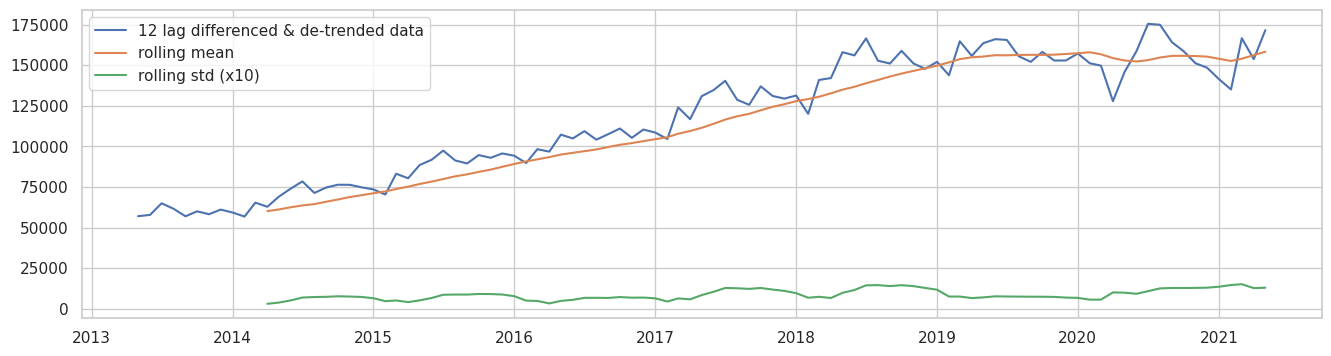

In [346]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)
test_stationarity(y,'12 lag differenced & de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced & de-trended data')
plt.show()

The results above after combining Differencing and Detrending show that the data is still not stationary.

So, I decided to differencing multiple time in other to make the data stationary since the above approaches do no stationarize the data.

 > Is the 12 lag differenced data 1 time stationary ?
Test statistic = -2.101
P-value = 0.244
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence


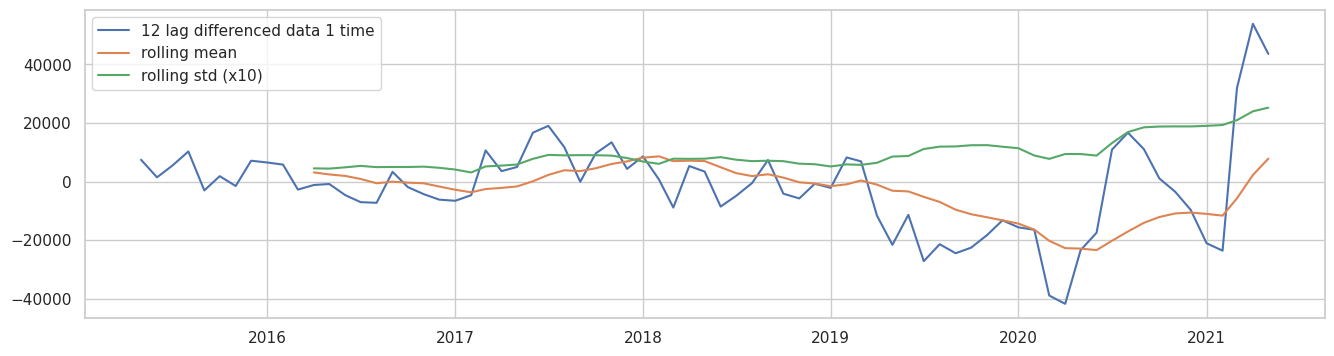

In [347]:
#Differencing -1
y_12lag1 = y_12lag - y_12lag.shift(12)

test_stationarity(y_12lag1,'12 lag differenced data 1 time')
ADF_test(y_12lag1,'12 lag differenced data 1 time')
plt.show()

The results above for Differencing the first time show that the data is still not stationary.

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.420
P-value = 0.010
Critical values :
	1%: -3.5714715250448363 - The data is not stationary with 99% confidence
	5%: -2.922629480573571 - The data is  stationary with 95% confidence
	10%: -2.5993358475635153 - The data is  stationary with 90% confidence


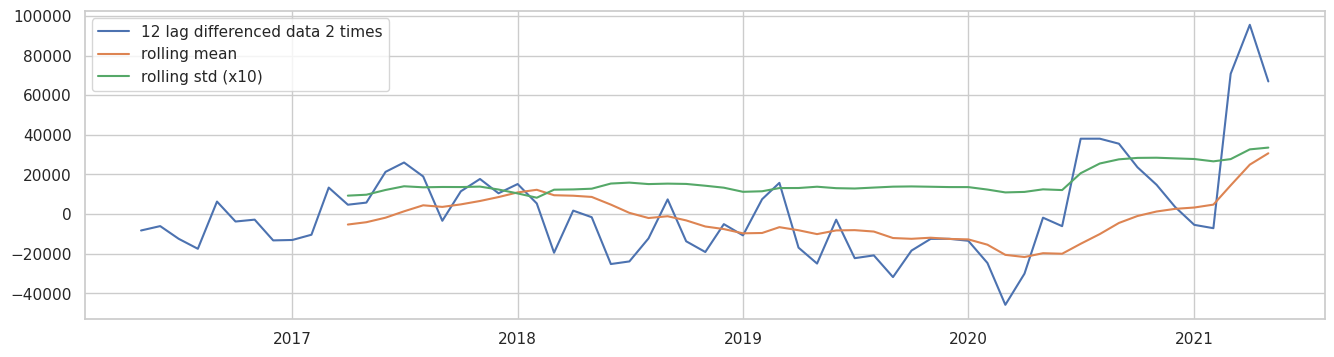

In [349]:
#Differencing -2 times
y_12lag2 = y_12lag1 - y_12lag1.shift(12)

test_stationarity(y_12lag2,'12 lag differenced data 2 times')
ADF_test(y_12lag2,'12 lag differenced data')
plt.show()

Differencing the second time did not perform but better than previous approaches, as indicated by the ADF test which is not stationary within 99 percent of the confidence interval.

 > Is the 12 lag differenced data 3 times stationary ?
Test statistic = -2.069
P-value = 0.257
Critical values :
	1%: -3.6209175221605827 - The data is not stationary with 99% confidence
	5%: -2.9435394610388332 - The data is not stationary with 95% confidence
	10%: -2.6104002410518627 - The data is not stationary with 90% confidence


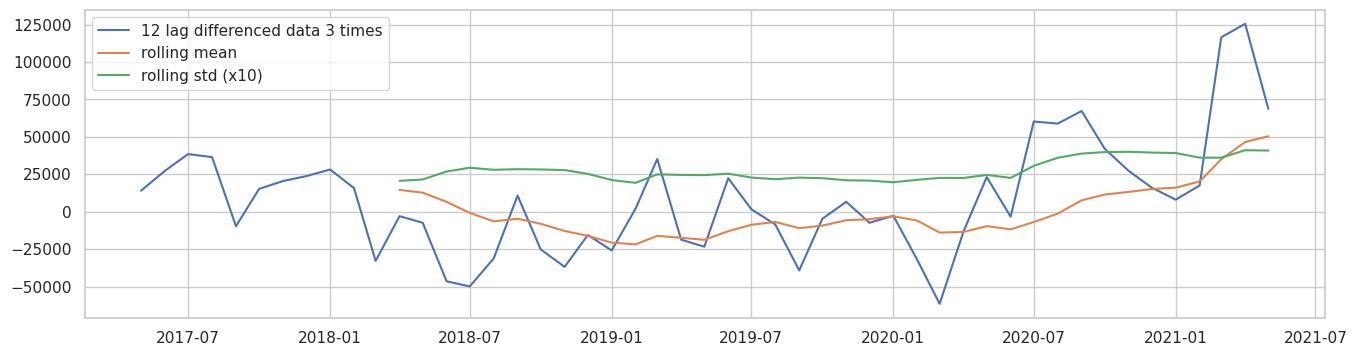

In [350]:
#Differencing -3 times
y_12lag3 = y_12lag2 - y_12lag2.shift(12)

test_stationarity(y_12lag3,'12 lag differenced data 3 times')
ADF_test(y_12lag3,'12 lag differenced data 3 times')
plt.show()

The results above for Differencing the third time show that the data is still not stationary.

 > Is the 12 lag differenced data 4 times stationary ?
Test statistic = -3.115
P-value = 0.025
Critical values :
	1%: -3.626651907578875 - The data is not stationary with 99% confidence
	5%: -2.9459512825788754 - The data is  stationary with 95% confidence
	10%: -2.6116707716049383 - The data is  stationary with 90% confidence


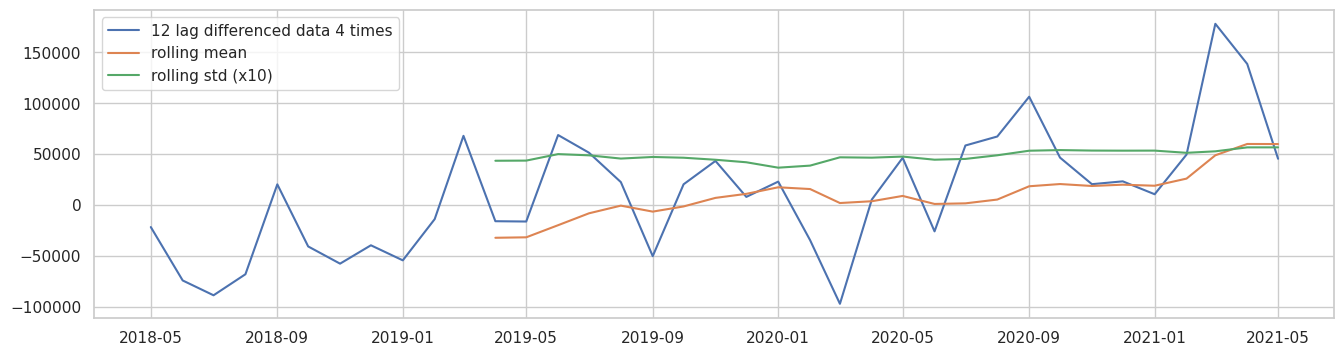

In [351]:
#Differencing -4 times
y_12lag4 = y_12lag3 - y_12lag3.shift(12)

test_stationarity(y_12lag4,'12 lag differenced data 4 times')
ADF_test(y_12lag4,'12 lag differenced data 4 times')
plt.show()

The results above for Differencing the fouth time show that the data is still not stationary.

 > Is the 12 lag differenced data 5 times stationary ?
Test statistic = -4.054
P-value = 0.001
Critical values :
	1%: -3.7529275211638033 - The data is  stationary with 99% confidence
	5%: -2.998499866852963 - The data is  stationary with 95% confidence
	10%: -2.6389669754253307 - The data is  stationary with 90% confidence


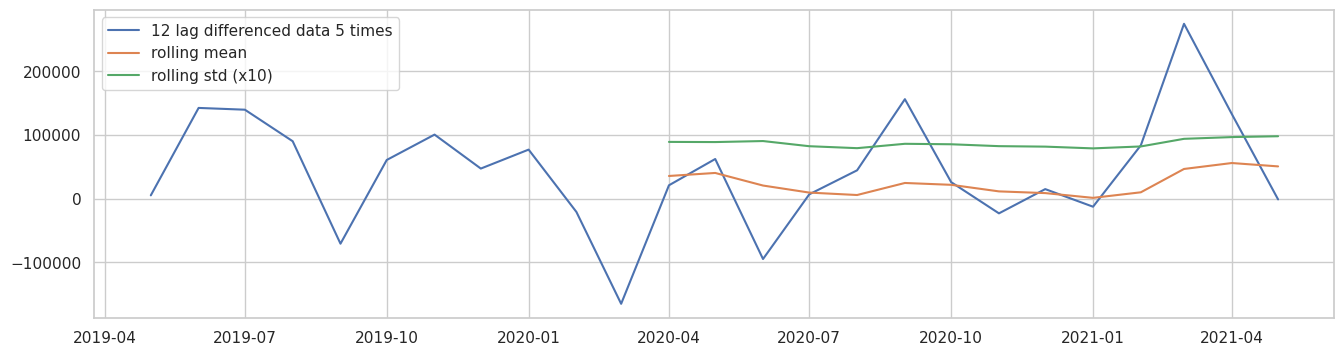

In [353]:
#Differencing -5 times
y_12lag5 = y_12lag4 - y_12lag4.shift(12)

test_stationarity(y_12lag5,'12 lag differenced data 5 times')
ADF_test(y_12lag5,'12 lag differenced data 5 times')
plt.show()

The results above show that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again by differencing for the fifth time.


<h1>Create Training & Testing Datasets</h1>

To evaluate the performance of the model I am considering for my time series analysis, I split the dataset into two parts.

One part is used for ‘Training’ dataset, and the other part is used for the ‘Testing’ dataset.


In [41]:
# training dataset which stopped in '2019-12-01' by using slice method
y_to_train = y[:'2019-12-01'] 
# testing dataset which started in '2020-01-01' by using slice method
y_to_test = y['2020-01-01':] 
y_to_val = y_to_test


<h2>SARIMA Model</h2>

Auto-Regressive Integrated Moving Average(ARIMA) models look at autocorrelations or serial correlations in the data. The ARIMA models look at differences between values in the time series. It is suitable for time series data with trend and/or seasonal components. SARIMA builds upon the concept of ARIMA but extends it to model the seasonal elements in my data. 

<h4>Generate the parameters List</h4>

In [42]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
p = d = q = range(0,2)
seasonal_period =12
pdq = list (itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list (itertools.product(p,d,q))]
                        
print ("Example of parameter combination for seasonal Arima model")
print ("SARIMAX: {} X {} ".format(pdq[1], seasonal_pdq[1]))                        
print ("SARIMAX: {} X {} ".format(pdq[1], seasonal_pdq[2]))                        
print ("SARIMAX: {} X {} ".format(pdq[2], seasonal_pdq[3]))  
print ("SARIMAX: {} X {} ".format(pdq[2], seasonal_pdq[4]))                        



Example of parameter combination for seasonal Arima model
SARIMAX: (0, 0, 1) X (0, 0, 1, 12) 
SARIMAX: (0, 0, 1) X (0, 1, 0, 12) 
SARIMAX: (0, 1, 0) X (0, 1, 1, 12) 
SARIMAX: (0, 1, 0) X (1, 0, 0, 12) 


In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q) that optimize a metric of interest. I am using the "grid search" to iteratively explore different combinations of parameters. The evaluation metric I use for the grid search is the AIC (Akaike Information Criterion) value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, I want to pick the combination with the lowest AIC value.

In [354]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'\
.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2093.7706805210405
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2074.069628217937
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1531.6278068921522
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1511.5745560627104
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1921.196184907741
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1800.4443487219032
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1486.6621924361039
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1435.2339364659
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2043.13084234109
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2036.7619764990368
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1490.669670700571
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1487.103313360989
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2032.967569890127
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2034.6734084075072
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1483.6783304342405
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1479.1360893578942
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1631.1129486820312
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:161

The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and as we can see that SARIMA(0, 1, 1)x(0, 1, 1, 12) has the lowest AIC value of 1307.5724706929755. Since this method chose the best parameters, I am using this method to fit my model.

In [44]:
# Using the training subset to train and fit the model

order = (1, 1, 0) #Using Values from the previous step
seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()


<h4>The diagnostic graphs shown below are explained here</h4>

1. The **Standardized resitual for "T"** shows the residuals over time. I do not want to see any obvious seasonality here and the messier it is, the better I can say I found the trend and seasonality in the data and removed the noise.

2. In the **Histogram plus estimated density**, I want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the **Normal Q-Q**, I am showing the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The **Correlogram** shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

By validating all the four points above, it is easy to conclude that this model’s residuals are near normally distributed. This indicates I have found a well-fit model suitable for our dataset.

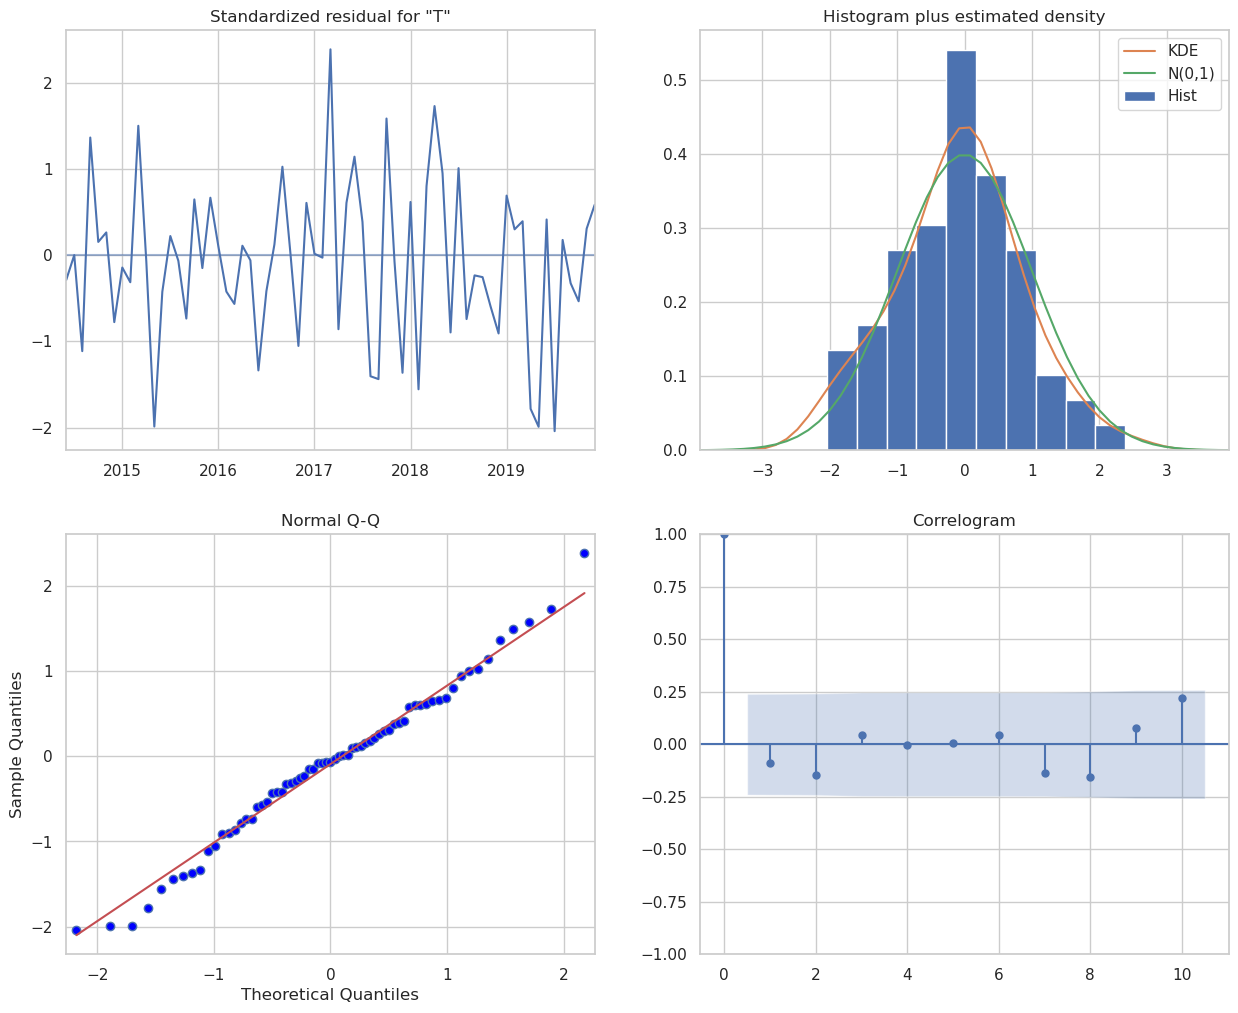

In [45]:
# Plot and check the diagnostics to ensure that results are within normal tolerance (most points within correlogram; 
# Q-Q plot nearly linear

results.plot_diagnostics(figsize=(15, 12))
plt.show()


<h2>Make and Check Forecasts</h2>

Since I have a well-fit model, then I can do some forecasting!

To get the forecast for the crime, I enter steps=12. The results produce both a table showing the Predicted_Mean, Lower Bound and Upper Bound, and the prediction graphs.

In [360]:
 # Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
    
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-01-01,155723.55657724,147274.97135358,164172.14180089
1,2020-02-01,147342.93016578,136382.28888506,158303.57144650
2,2020-03-01,167736.02743701,154601.73201280,180870.32286123
3,2020-04-01,161361.50118250,146386.62581478,176336.37655022
4,2020-05-01,171485.02045455,154868.93514423,188101.10576488
5,2020-06-01,172981.89250680,154873.26052042,191090.52449318
6,2020-07-01,175514.11604420,156026.83471160,195001.39737681
7,2020-08-01,164689.10952982,143914.48224114,185463.73681850
8,2020-09-01,161832.66681957,139845.93799994,183819.39563921
9,2020-10-01,168626.75329402,145491.34035091,191762.16623714


In [46]:
# Forecast 12 months ahead of the training data
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()


# Prediction using data prior to the first lockdown of Violence and sexual offences levels for April 2020

The prediction using data prior to the first lockdown is forecast to be close 170,000. 

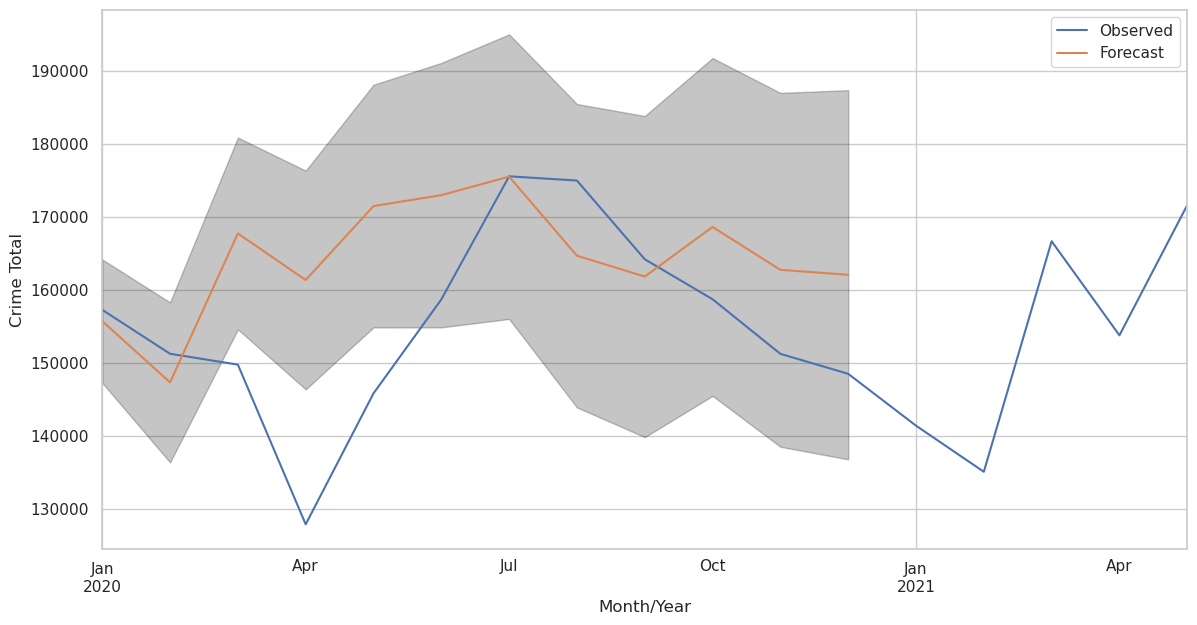

In [361]:
ax = y_to_test.plot(label='Observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month/Year')
ax.set_ylabel('Crime Total')

plt.legend()
plt.show()


You can see from the visualization above that our model clearly captured the seasonality as well as the increasing trend of the crime.

# Compare predicted crime levels with actuals, and so determine whether significant changes to Violence and sexual offences  occurred!


The gray area in the diagram below represents the 95 percent confidence interval and as with virtually all forecasting models, as the predictions go further into the future, the less confidence we have in the values. In this case, it is 95 percent confident that the actual crime will fall inside this range. But, there is a chance the actuals could also fall completely outside this range. The larger the future time period for which we want to predict, the larger this confidence range will be (that is, the less precise our forecast is).

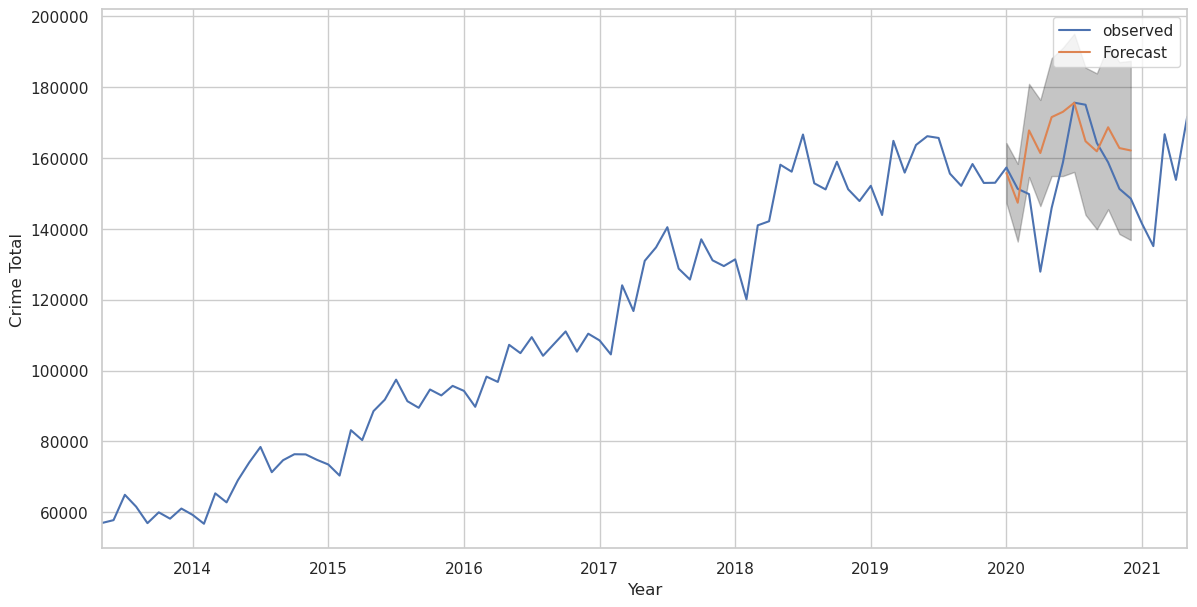

In [50]:
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Crime Total')

plt.legend()
plt.show()


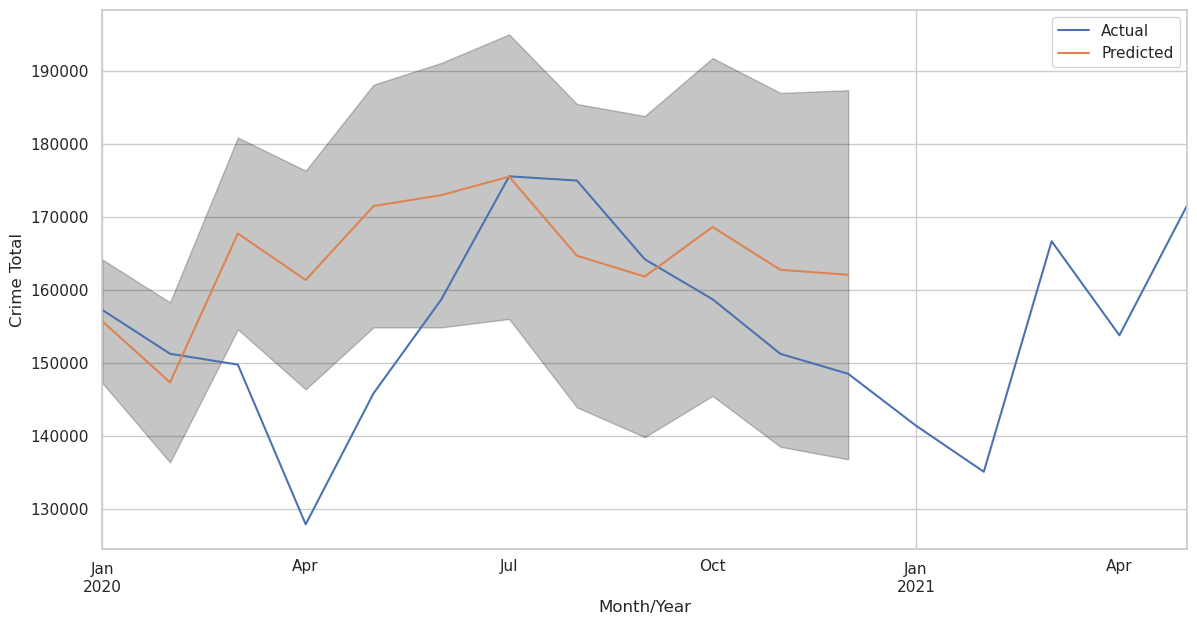

In [61]:
ax = y_to_test.plot(label='Actual', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Predicted')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month/Year')
ax.set_ylabel('Crime Total')

plt.legend()
plt.show()


In other to display the gray area, I decided to show the only part alone in the above diagram.

# The Leicester region was put in a local lockdown in July 2020. Verify your findings (if any) with respect to that region only.

To verify whether the Leicester region was put in a lockdown in July 2020, I filter the location based on the region of leicester. The aggregate function is used to get the total number of crime and it's being sorted by Month.

In [ ]:
ds_location = (df.select('*')
        .where(df['Month']>='2020-03')
        .groupBy('Crime Type', 'Month','location')
        .agg(count("Crime Type").alias('Total Crime'))
        .orderBy('Month')

In [375]:
# filtering the dataset using location
ds_location_2 = ds_location.where('location like "%Midlands%" or location like "%Leicester%"')

In [240]:
ds_location_region = ds_location_2.where(ds_location_2['Crime Type']=='Violence and sexual offences')
ds_location_region.show()


+--------------------+-------+--------------------+-----------+
|          Crime Type|  Month|            location|Total Crime|
+--------------------+-------+--------------------+-----------+
|Violence and sexu...|2020-03|On or near Leices...|         16|
|Violence and sexu...|2020-03|On or near Leices...|          6|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|         23|
|Violence and sexu...|2020-03|On or near Leices...|          2|
|Violence and sexu...|2020-03|On or near Leices...|         10|
|Violence and sexu...|2020-03|On or near Leices...|          3|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|          2|
|Violence and sexu...|2020-04|On or near Leices...|         21|
|Violence and sexu...|2020-04|On or near

In [376]:
ds_location_region = ds_location_2.where(ds_location_2['Crime Type']=='Violence and sexual offences')
ds_location_region.show()

+--------------------+-------+--------------------+-----------+
|          Crime Type|  Month|            location|Total Crime|
+--------------------+-------+--------------------+-----------+
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|         16|
|Violence and sexu...|2020-03|On or near Leices...|          2|
|Violence and sexu...|2020-03|On or near Leices...|          3|
|Violence and sexu...|2020-03|On or near Leices...|         23|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|          6|
|Violence and sexu...|2020-03|On or near Leices...|         10|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|          1|
|Violence and sexu...|2020-03|On or near Leices...|          2|
|Violence and sexu...|2020-04|On or near Leices...|          3|
|Violence and sexu...|2020-04|On or near

In [244]:
# converting to pandas
ds_location_region_pd = ds_location_region.toPandas()
ds_location_region_pd


,Crime Type,Month,location,Total Crime
0,Violence and sexual offences,2020-03,On or near Leicester Crescent,1
1,Violence and sexual offences,2020-03,On or near Leicester Close,3
2,Violence and sexual offences,2020-03,On or near Leicester Street,10
3,Violence and sexual offences,2020-03,On or near Leicester Square,1
4,Violence and sexual offences,2020-03,On or near Leicester Road,23
...,...,...,...,...
175,Violence and sexual offences,2021-05,On or near Old Leicester Road,1
176,Violence and sexual offences,2021-05,On or near Leicester Street,11
177,Violence and sexual offences,2021-05,On or near Leicester Grove,1
178,Violence and sexual offences,2021-05,On or near Leicester Royal Infirmiry,17


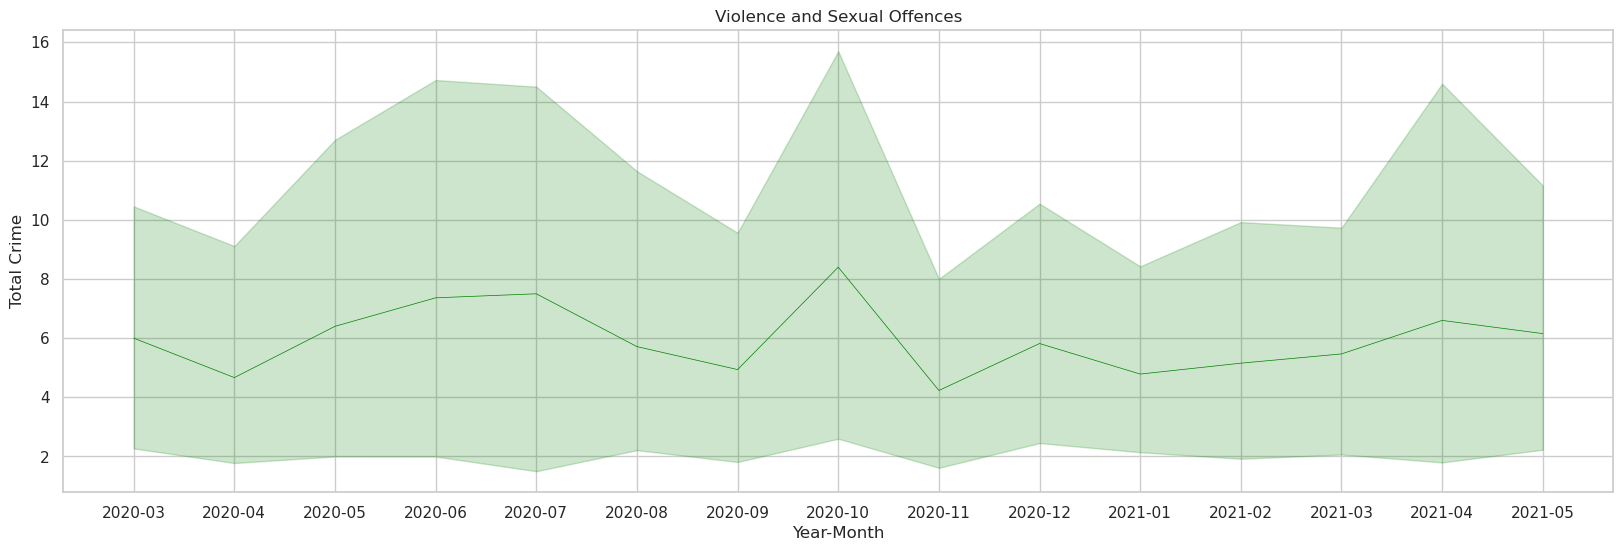

In [246]:
plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=ds_location_region_pd,x='Month',y="Total Crime", color='green', linewidth=0.5)
ax.set_title("Violence and Sexual Offences")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Crime")
plt.show()

The above diagram showed that there is an increase in July 2020 which could have led to the lockdown in the region.

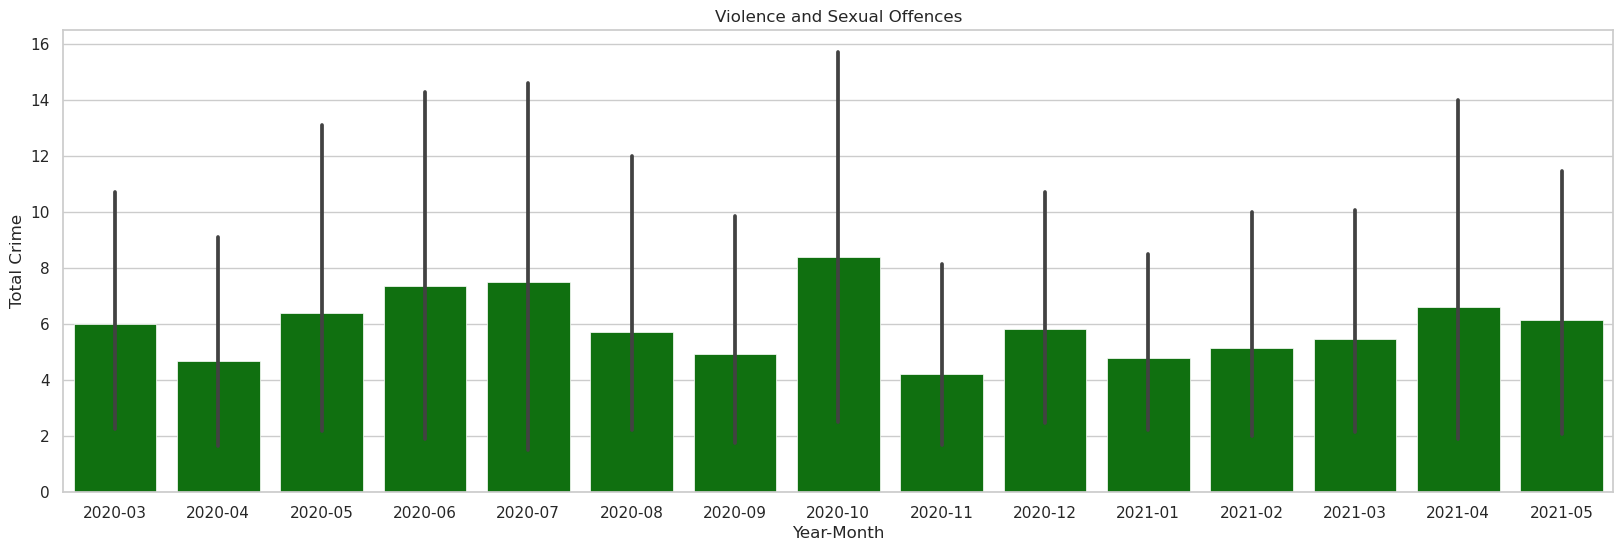

In [247]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=ds_location_region_pd,x='Month',y="Total Crime", color='green', linewidth=0.5)
ax.set_title("Violence and Sexual Offences")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Crime")
plt.show()

<h2>LSOA DATASET</h2>

The LSOA DATASET does not have enough data to use. The date in the dataset is only 2011 and that is why I used the "All crime dataset" for my location.

In [249]:

url_location = "https://yusuf.blob.core.windows.net/container20027750/LSOA_pop_v2.csv"
spark_context.addFile(url_location)

df_location = spark.read.csv(SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)
df_location.show()

df_location.count()


+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+------------

34753

In [250]:
df_location_pd=df_location.toPandas()
df_location_pd


,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4
1,2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1
2,2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3
3,2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3
4,2011,Darlington 001F,E01033482,Total,1621,810,811,1621,0,16,234.31,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...
34748,2011,Newport 020A,W01001636,Total,1897,944,953,1897,0,25,1151.60,1.6
34749,2011,Newport 020C,W01001657,Total,1465,721,744,1463,2,38,881.84,1.7
34750,2011,Newport 020D,W01001658,Total,1885,891,994,1848,37,23,365.14,5.2
34751,2011,Newport 020E,W01001912,Total,1480,739,741,1476,4,22,1607.09,0.9


In [380]:
ds_lsoa_location = (df_location.select('*')
        .where(df_location['date']>='2011')
        .groupBy('date', 'geography code','geography')
        .agg(count("geography").alias('Total'))
       .orderBy('date')
               )

ds_lsoa_location.show()›



+----+--------------+--------------------+-----+
|date|geography code|           geography|Total|
+----+--------------+--------------------+-----+
|2011|     E01020649|  County Durham 008C|    1|
|2011|     E01012011|  Middlesbrough 008A|    1|
|2011|     E01027461| Northumberland 016E|    1|
|2011|     E01012105|Redcar and Clevel...|    1|
|2011|     E01012131|Redcar and Clevel...|    1|
|2011|     E01008182|      Gateshead 004C|    1|
|2011|     E01008747|     Sunderland 035D|    1|
|2011|     E01012674|      Blackpool 013C|    1|
|2011|     E01018586|  Cheshire East 001B|    1|
|2011|     E01018721|Cheshire West and...|    1|
|2011|     E01012399|         Halton 013D|    1|
|2011|     E01019146|Barrow-in-Furness...|    1|
|2011|     E01005312|     Manchester 036E|    1|
|2011|     E01005715|        Salford 007E|    1|
|2011|     E01005852|      Stockport 013A|    1|
|2011|     E01005795|      Stockport 039D|    1|
|2011|     E01005955|       Tameside 002D|    1|
|2011|     E01005979

In [258]:
ds_lsoa_location_pd=ds_lsoa_location.toPandas()
ds_lsoa_location_pd

,date,geography code,geography,Total Crime
0,2011,E01020649,County Durham 008C,1
1,2011,E01012011,Middlesbrough 008A,1
2,2011,E01027461,Northumberland 016E,1
3,2011,E01012105,Redcar and Cleveland 002A,1
4,2011,E01012131,Redcar and Cleveland 005E,1
...,...,...,...,...
34748,2011,W01001722,Cardiff 028D,1
34749,2011,W01001226,Rhondda Cynon Taf 031F,1
34750,2011,W01001359,Caerphilly 006D,1
34751,2011,W01001584,Monmouthshire 008B,1


# References

Nielsen, A., 2019. Practical time series analysis: Prediction with statistics and machine learning. O'Reilly Media.!

Shao, V., 2020. Forecasting with a Time Series Model using Python.

Vincent T., 2017, Time Series Visualization and Forecasting https://www.digitalocean.com/community/tutorial_series/time-series-visualization-and-forecasting Accessed Jan 4


